# Fit Luminosity function Schechter function on DC2-DP0 to study bias


- Adapted and commented by Sylvie Dagoret-Campagne from ixkael notebook https://github.com/ixkael/Photoz-tools
- Creation date : April 29th 2022


In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Trick to remove bad python path

In [3]:
import sys
print(sys.path)

['/pbs/throng/lsst/users/dagoret/desc/Photoz-tools', '', '/opt/conda/lib/python3.8/site-packages', '/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python38.zip', '/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8', '/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/lib-dynload', '/pbs/home/d/dagoret/.local/lib/python3.8/site-packages', '/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages', '/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/Deprecated-1.2.11-py3.8.egg', '/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/docopt-0.6.2-py3.8.egg', '/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/mimeparse-0.1.3-py3.8.egg', '/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg', '/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/rail-0.1.dev0-py3.8.egg', '/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib

In [4]:
all_paths_to_remove = ['/opt/conda/lib/python3.8/site-packages','/pbs/home/d/dagoret/.local/lib/python3.8/site-packages']

In [5]:
for path_to_remove in all_paths_to_remove:
    if path_to_remove in sys.path:
        print(f"remove {path_to_remove} from sys.path")
        sys.path.remove(path_to_remove)

remove /opt/conda/lib/python3.8/site-packages from sys.path
remove /pbs/home/d/dagoret/.local/lib/python3.8/site-packages from sys.path


# Typical import

In [6]:
%matplotlib inline
import numpy as np
import tables as tb
from matplotlib.ticker import FormatStrFormatter
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline, interp1d
from scipy.special import erfc
import pandas as pd
import seaborn as sns 
import itertools
sns.set_style("white")
sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 2.5})
sns.set_palette(sns.color_palette(["#9b59b6", "#95a5a6", 
                                   "#e74c3c", "#3498db", 
                                   "#34495e", "#2ecc71"]))

In [7]:
import os

In [8]:
# DP0 - DC2 extracted from Science Rubin Platform at https://data.lsst.cloud/  
# with  https://github.com/sylvielsstfr/MyDP0LSS/blob/main/09_MLscikitL_PhotoZ_part3.ipynb
inputdatadir                  = "/sps/lsst/groups/photoz/DC2DP0"
filename_dp0dc2_h5             = "catdp0dc2_photoz_result.h5"
fullfilename_dp0dc2_h5         = os.path.join(inputdatadir,filename_dp0dc2_h5)  

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
# Set up some plotting defaults:

params = {'axes.labelsize': 28,
          'font.size': 24,
          'legend.fontsize': 14,
          'xtick.major.width': 3,
          'xtick.minor.width': 2,
          'xtick.major.size': 12,
          'xtick.minor.size': 6,
          'xtick.direction': 'in',
          'xtick.top': True,
          'lines.linewidth': 3,
          'axes.linewidth': 3,
          'axes.labelweight': 3,
          'axes.titleweight': 3,
          'ytick.major.width': 3,
          'ytick.minor.width': 2,
          'ytick.major.size': 12,
          'ytick.minor.size': 6,
          'ytick.direction': 'in',
          'ytick.left': True,
          'figure.figsize': [18, 10],
          'figure.facecolor': 'White'
          }

plt.rcParams.update(params)

In [11]:
import scipy.special as sc

# Few definitions

## Interface to data

In [12]:
def readfromdp0rsp(h5file):
    """
    convertformatdc2fromdp0rsp : access to H5 file from DP0-RSP
    
    input : H5 file descriptor
    output : datasets
    
    """
    df = pd.read_hdf(h5file,'/photoz')
    return df

In [13]:
m5u = 25.613 #/ 26.100
m5g = 26.678 #/ 27.400
m5r = 26.608 #/ 27.500
m5i = 25.931 #/ 26.800
m5z = 24.732 #/ 26.100
m5y = 23.954 #/ 24.900

def photodet_select(mu,mg,mr,mi,mz,my, UMAX=m5u, GMAX=m5g, RMAX = m5r, IMAX= m5i, ZMAX=m5z, YMAX=m5y):
    return (mu>17) and (mu < UMAX) and (mg < GMAX) and (mr < RMAX) and (mi < IMAX) and (mz < ZMAX) and (my < YMAX)

In [14]:
def selectdc2fromdp0rsp(df, Ntrain=10000,FLAG_APPLYM5CUT = True):
    """
    selectfromdp0rsp : 
    
    input : dataframe
    output : datasets
    
    """
    
    # apply m5 cutoff
    if FLAG_APPLYM5CUT :
        df['selected'] = df.apply(lambda x:  photodet_select(x['mag_u'], x['mag_g'], x['mag_r'], x['mag_i'],x['mag_z'], x['mag_y'] ), axis=1)
        df = df[df["selected"]]
        df = df.drop('selected', axis=1)
        
    df = df.dropna()
    df.reset_index()
    
    Ntot = len(df)
    assert Ntot>Ntrain
    Ntest = Ntot-Ntrain
    
    
    # Test fraction
    test_sample_size_fraction=Ntest/Ntot
    test_sample_size_fraction
    
    
    # split in train/test
    target = df["redshift"]
    features = df[["mag_u","mag_g","mag_r","mag_i","mag_z","mag_y","magerr_u","magerr_g","magerr_r","magerr_i","magerr_z","magerr_y","umg","gmr","rmi","imz","zmy"]]
    
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=test_sample_size_fraction, random_state=0)
    return X_train, X_test, y_train, y_test 

## access to DC2 data from catalog extracted from DP0 in RSP

In [15]:
df = readfromdp0rsp(fullfilename_dp0dc2_h5) 

In [16]:
# df.head()

In [17]:
X_train, X_test, y_train, y_test = selectdc2fromdp0rsp(df)

In [18]:
del X_test
del y_test

## Redshift priors

In [19]:
# This is the prior HDFN prior from Benitez 2000, adapted from the BPZ code.
# This could be replaced with any redshift, magnitude, and type distribution.
def bpz_prior(z, m, nt):
    nz = len(z)
    momin_hdf = 20.
    if m>32.: m = 32.
    if m<20.: m = 20.    
    # nt Templates = nell Elliptical + nsp Spiral + nSB starburst
    try:  # nt is a list of 3 values
        nell, nsp, nsb = nt
    except:  # nt is a single value
        nell = 1  # 1 Elliptical in default template set
        nsp = 2   # 2 Spirals in default template set
        nsb = nt - nell - nsp  # rest Irr/SB
    nn = nell, nsp, nsb
    nt = sum(nn)
    # See Table 1 of Benitez00
    a  = 2.465,  1.806,  0.906
    zo = 0.431,  0.390,  0.0626
    km = 0.0913, 0.0636, 0.123
    k_t= 0.450,  0.147
    a  = np.repeat(a, nn)
    zo = np.repeat(zo, nn)
    km = np.repeat(km, nn)
    k_t= np.repeat(k_t, nn[:2])
    # Fractions expected at m = 20: 35% E/S0, 50% Spiral, 15% Irr
    fo_t = 0.35, 0.5
    fo_t = fo_t / np.array(nn[:2])
    fo_t = np.repeat(fo_t, nn[:2])
    dm = m-momin_hdf
    zmt = np.clip(zo+km*dm,0.01,15.)
    zmt_at_a = zmt**(a)
    zt_at_a = np.power.outer(z,a)
    #Morphological fractions
    nellsp = nell + nsp
    f_t = np.zeros((len(a),),float)
    f_t[:nellsp] = fo_t*np.exp(-k_t*dm)
    f_t[nellsp:] = (1.-np.add.reduce(f_t[:nellsp]))/float(nsb)
    #Formula: zm=zo+km*(m_m_min)  and  p(z|T,m)=(z**a)*exp(-(z/zm)**a)
    p_i = zt_at_a[:nz,:nt]*np.exp(-np.clip(zt_at_a[:nz,:nt]/zmt_at_a[:nt],0.,700.))
    #This eliminates the very low level tails of the priors
    norm = np.add.reduce(p_i[:nz,:nt],0)
    p_i[:nz,:nt] = np.where(np.less(p_i[:nz,:nt]/norm[:nt],1e-2/float(nz)),
              0.,p_i[:nz,:nt]/norm[:nt])
    norm = np.add.reduce(p_i[:nz,:nt],0)
    p_i[:nz,:nt] = p_i[:nz,:nt]/norm[:nt]*f_t[:nt]
    return p_i

## More definitions

- redshift grid

- priors for different types of galaxies

/tmp/ipykernel_668/2857964022.py:38: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax.legend(p, labels=names)


Text(0.5, 0, 'redshift')

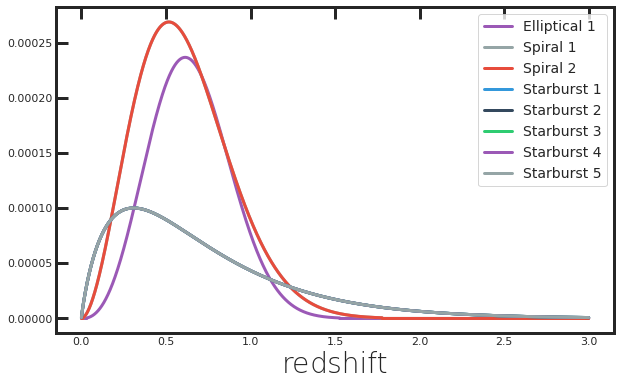

In [20]:
# This is the "fine" redshift grid we will use
z_grid_binsize = 0.001
z_grid_edges = np.arange(0.0, 3.0, z_grid_binsize)
z_grid = (z_grid_edges[1:] + z_grid_edges[:-1])/2.

# Just some boolean indexing of templates used. Needed later for some BPZ fcts.
selectedtemplates = np.repeat(False, 8)

# Using all templates
templatetypesnb = (1, 2, 5) # nb of ellipticals, spirals, and starburst used in the 8-template library.
selectedtemplates[:] = True

# Uncomment that to use three templates using
#templatetypesnb = (1,1,1) #(1,2,8-3) 
#selectedtemplates[0:1] = True
nt = sum(templatetypesnb)

ellipticals = ['El_B2004a.sed'][0:templatetypesnb[0]]
spirals = ['Sbc_B2004a.sed','Scd_B2004a.sed'][0:templatetypesnb[1]]
irregulars = ['Im_B2004a.sed','SB3_B2004a.sed','SB2_B2004a.sed',
           'ssp_25Myr_z008.sed','ssp_5Myr_z008.sed'][0:templatetypesnb[2]]
template_names = [nm.replace('.sed','') for nm in ellipticals+spirals+irregulars]

# Use the p(z,t,m) distribution defined above
m = 22.0 # some reference magnitude
p_z__t_m = bpz_prior(z_grid, m, templatetypesnb)

# Convenient function for template names
def mknames(nt):
    return ['Elliptical '+str(i+1) for i in range(nt[0])] \
    + ['Spiral '+str(i+1) for i in range(nt[1])]\
    + ['Starburst '+str(i+1) for i in range(nt[2])]
names = mknames(templatetypesnb)

# Plot the priors for these templates
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
p = ax.plot(z_grid, p_z__t_m)
ax.legend(p, labels=names)
ax.set_xlabel("redshift")

# Load and plot the templates and filters

- (With LSST filters)

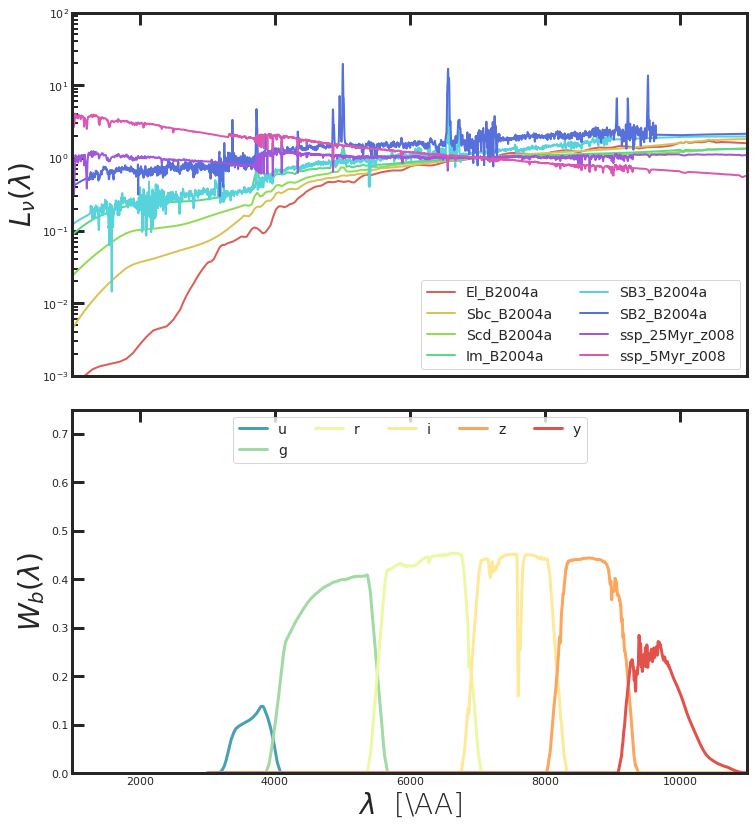

In [21]:
# Load and plot the templates and filters
#palette = itertools.cycle(sns.color_palette())
palette = itertools.cycle(sns.color_palette("hls", nt))

fig, axs = plt.subplots(2, 1, figsize=(11, 12), sharex=True)
for i, template_name in enumerate(template_names):
    data = np.genfromtxt('./seds/'+template_name+'.sed')
    wavelength, template_sed = data[:,0], data[:,1] * data[:,0]**2
    fnorm = np.interp(7e3, wavelength, template_sed)
    axs[0].plot(wavelength, (template_sed / fnorm), label=template_names[i], 
                c=next(palette), lw=2)
axs[0].legend(loc='lower right', ncol=2)
axs[0].set_ylabel(r'$L_\nu(\lambda)$')
axs[0].set_yscale('log')
axs[0].set_ylim([1e-3, 1e2])

ab_filters = ['u', 'g', 'r', 'i', 'z','y']
#palette = itertools.cycle(sns.cubehelix_palette(6, light=0.6))
palette = itertools.cycle(reversed(sns.color_palette("Spectral",6)))
filters = [np.genfromtxt('./filters_lsst/DC2LSST_'+band+'.res') for band in ab_filters]
for f, data in zip(ab_filters, filters):
    axs[1].plot(data[:,0], data[:,1], label=f, c=next(palette), lw=3)
axs[1].set_xlim([1e3, 1.1e4])
axs[1].set_ylim([0, 0.75])
axs[1].set_xlabel(r'$\lambda$  [\AA]')
axs[1].set_ylabel(r'$W_b(\lambda)$')
axs[1].legend(loc='upper center', ncol=5)
fig.tight_layout()

## Distribution of magnitude or magnitude errors

### Distribution of magnitude 

- we know that for a fixed detection threshold on flux, , for a staticEuclidan universe, we have the following distribution on magnitude :
$$
\frac{dN}{dm} \simeq 10^{0.6 m}
$$

which is derived from the relation
$$
\frac{dN}{dF} \simeq \left( \frac{F}{F_{min}}\right)^{-\frac{5}{2}}
$$

But here the expression for the probability of the magnitude distribution retlated to a $m_{max}$ magnitude taken to be:
$$
p(m) = m^\alpha \exp\left(- (\frac{m}{m_{max}-\delta m})^\beta \right) 
$$

- where $\alpha, \beta, m_{max}$ and $\delta m$ are parameters (these could be related to what we call m-5sigma detection threshold).

- this is probably to describe the effect of the detection threshold.

This formula may be checked on LSST data

In [22]:
maglim = 24  # magnitude limit
off = 1.  # some offset
imag_grid = np.linspace(17, 26, num=200)  # grid for i magnitude
imagerr_grid = np.linspace(0, 0.4, num=200)  # grid for i magnitude error

# some parameters for prob(imagnitude)
alpha = 15.0 
beta = 2

# prob(imagnitude) distribution
p_imag = imag_grid**alpha*np.exp(-(imag_grid/(maglim-off))**beta)
p_imag /= p_imag.sum()

### Distribution of magnitude errors

why not
$$
F = 10^{-0.4(m-22.5)}
$$

This formula may be compared to the one in LSST science book
- the parameters has probably been fitted on simulations (or data)

In [23]:
# imag errir distribution as function of mag limit, as in Rykoff et al
# But we need to really understand how imag_err is defined
# this seams to be an error in magnitude units
def imag_err(m, mlim):
    a, b = 4.56, 1
    k = 1
    sigmadet = 5
    teff = np.exp(a + b * (mlim - 21.))
    F = 10**(-0.4*(m-22.5))
    Flim = 10**(-0.4*(mlim-22.5))
    Fnoise = (Flim/sigmadet)**2 * k * teff - Flim
    return 2.5/np.log(10) * np.sqrt( (1 + Fnoise/F) / (F*k*teff))
    

### Plot magnitude distribution and 

Text(0.5, 0, 'imag')

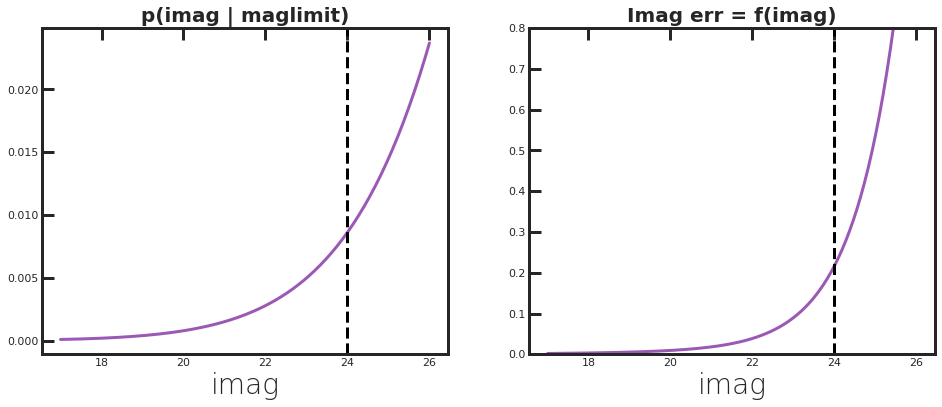

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
axs[0].plot(imag_grid, p_imag)
axs[0].axvline(maglim, c='k', ls='dashed')
axs[0].set_title('p(imag | maglimit)',fontweight="bold",fontsize=20)
axs[0].set_xlabel("imag")
axs[1].plot(imag_grid, imag_err(imag_grid, maglim))
axs[1].axvline(maglim, c='k', ls='dashed')
axs[1].set_title('Imag err = f(imag)',fontweight="bold",fontsize=20)
axs[1].set_ylim([0, 0.8])
axs[1].set_xlabel("imag")

- But in this equation $p(imag)$ goes to infinity when $imag$ goes to infinity. No experimental cutoff is introduced.

In [32]:
galaxies_mapping = {}
for tt in range(nt):
    galaxies_mapping[tt] = names[tt]

In [33]:
galaxies_mapping

{0: 'Elliptical 1',
 1: 'Spiral 1',
 2: 'Spiral 2',
 3: 'Starburst 1',
 4: 'Starburst 2',
 5: 'Starburst 3',
 6: 'Starburst 4',
 7: 'Starburst 5'}

In [28]:
names

['Elliptical 1',
 'Spiral 1',
 'Spiral 2',
 'Starburst 1',
 'Starburst 2',
 'Starburst 3',
 'Starburst 4',
 'Starburst 5']

## Build the flux-redshift model

A) Convert $L_\lambda(\lambda)$ into $L_\nu(\lambda)$
The input SED file are tabulated in $\frac{dE}{d\lambda}=L_\lambda(\lambda)$, but
for using AB system, we need to transform it into $\frac{dE}{d\nu}=L_\nu(\lambda)$.

$$
\frac{dE}{d\nu} = \frac{d\lambda}{d\nu}\frac{dE}{d\lambda}
$$
or
$$
L_\nu(\lambda) = \frac{d\lambda}{d\nu}L_\lambda(\lambda)
$$
Because $\lambda = c/\nu$ , then $d\lambda/d\nu = c/\nu^2 = \lambda^2/c$, then
$$
L_\nu(\lambda) = \frac{\lambda^2}{c}L_\lambda(\lambda)
$$

B) Normalize $L_\nu(\lambda)$ at $\lambda = \lambda_{ref}$
$$
L_\nu(\lambda)= \frac{L_{\lambda}(\lambda) \lambda^2}{L_\lambda(\lambda_{ref}) \lambda_{ref}^2}
$$

C) Flux density distribution from luminosity
$$
f_{\nu}(\lambda_{obs},z) = \frac{1+z}{4\pi D_L^2(z)} L_{\nu}\left( \frac{\lambda_{obs}}{1+z} \right) 
$$

D) Flux in filter band $b$ with the transmission $W_b(\lambda)$
$$
F_b(\lambda_{obs},z) = \frac{1}{g_{AB}C_b}\int_0^\infty W_b(\lambda_{obs}) f_{\nu}(\lambda_{obs},z) \frac{d\lambda_{obs}}{\lambda_{obs}}
$$

Defining $C_b = \int_0^\infty W_b(\lambda) \frac{d\lambda}{\lambda}$ and $V_b(\lambda) = W_b(\lambda)/\lambda$,

$$
F_b(\lambda_{obs},z) = \frac{(1+z)^2}{4 \pi D_L^2(z)g_{AB}C_b}\int_0^\infty L_\nu(\lambda_{em},z )V_b\left(\lambda_{em}(1+z)\right)  d\lambda_{em}
$$

In [29]:

filters = ['u', 'g', 'r', 'i', 'z','y'] # Which bands are used
reffilter = 2 # Which one is the reference? i band by default but could be anything.

# Approximate luminosity distance for flat LCDM
def DL(z):
    return np.exp(30.5 * z**0.04 - 21.7)

# We will now use the BPZ routines to load the magnitude-redshift model for each template.
# We'll have interpolated and discretized versions
nf = len(filters)
nz = len(z_grid)

# container for the model in 3D : redshift , type, filter
f_mod = np.zeros((nz,nt,nf))*0.
f_mod_interps = np.zeros((nt, nf), dtype=interp1d)
lambdaRef = 4.5e3

# loop on templates
for it in range(nt):
    
    # compute 
    seddata = np.genfromtxt('./seds/' + template_names[it] + '.sed')
    seddata[:, 1] *= seddata[:, 0]**2. / 3e18  # why divide by 3e18
    
    # get the reference value of SED to normalize at lambda_ref
    ref = np.interp(lambdaRef, seddata[:, 0], seddata[:, 1])
    seddata[:, 1] /= ref
    sed_interp = interp1d(seddata[:, 0], seddata[:, 1])
    
    # loop on filters
    for jf in range(nf):
        data = np.genfromtxt('./filters_lsst/DC2LSST_' + filters[jf] + '.res')
        xf, yf = data[:, 0], data[:, 1]  # lambda_obs, W_b(lambda_obs) transmission
        yf /= xf  # divide filter transmission by lambda to get V_b(lambda_obs)
        # Only consider range where >1% max
        ind = np.where(yf > 0.01*np.max(yf))[0]
        lambdaMin, lambdaMax = xf[ind[0]], xf[ind[-1]]
        norm = np.trapz(yf, x=xf)  # compute Cb (computed in lambda_{obs} frame)
        for iz in range(z_grid.size):
            opz = (z_grid[iz] + 1)  # (1+z)
            xf_z = np.linspace(lambdaMin / opz, lambdaMax / opz, num=5000) # define lambda_em
            yf_z = interp1d(xf / opz, yf)(xf_z)  # lambda_em --> Vb(lambda_obs)  OK !
            ysed = sed_interp(xf_z)
            f_mod[iz, it, jf] = np.trapz(ysed * yf_z, x=xf_z) / norm
            f_mod[iz, it, jf] *= opz**2. / DL(z_grid[iz])**2. / (4*np.pi)
        f_mod_interps[it, jf] = InterpolatedUnivariateSpline(z_grid, f_mod[:, it, jf])

## Check SED model

Text(0.5, 0, 'wavelength $\\lambda  (\\AA)$')

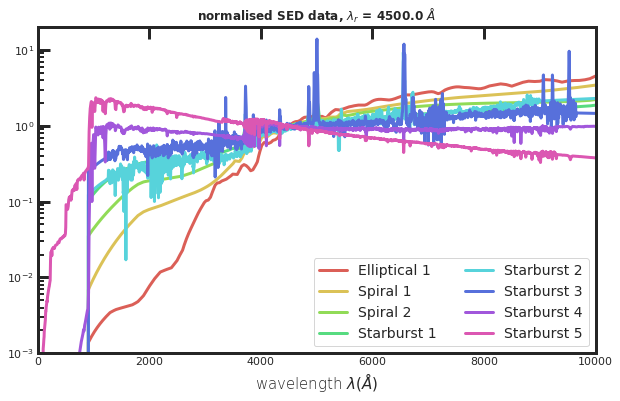

In [30]:
fig = plt.figure(figsize=(10,6))
ax  = fig.add_subplot(1,1,1)
palette = itertools.cycle(sns.color_palette("hls", nt))
for it in range(nt):
    seddata_2 = np.genfromtxt('./seds/' + template_names[it] + '.sed')
    seddata_2[:, 1] *= seddata_2[:, 0]**2. / 3e18
    ref = np.interp(lambdaRef, seddata_2[:, 0], seddata_2[:, 1])
    seddata_2[:, 1] /= ref
    ax.plot(seddata_2[:, 0], seddata_2[:, 1],color=next(palette),label=names[it])
ax.set_yscale("log")
ax.legend(ncol=2)
ax.set_ylim(1e-3,20)
ax.set_xlim(0,1e4)
ax.set_title(f"normalised SED data, $\\lambda_r$ = {lambdaRef} $\\AA$ ",fontweight="bold")
ax.set_xlabel("wavelength $\\lambda  (\\AA)$",fontsize=15)

## Flux Redshift Model

NameError: name 'train_z' is not defined

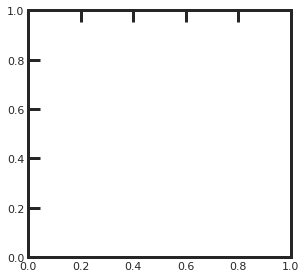

In [31]:
#sns.set_color_codes("dark")
col_data = ["blue", "green","red","orange","grey","purple"]
fig = plt.figure(figsize=(16,10))
for jf in range(nf):
    palette = itertools.cycle(sns.color_palette("hls", nt))
    ax  = fig.add_subplot(2,3,jf+1)
    x_data = train_z
    y_data = train_data_mags[:,jf]
    idx_data = np.where(y_data < 98)[0]
    x_data = x_data[idx_data]
    y_data = y_data[idx_data]
    sns.scatterplot(x=x_data,y=y_data,color=col_data[jf],alpha=0.005,markers=".",sizes=0.05)   
    for it in range(nt):
       
        ax.plot(z_grid,-2.5*np.log10(f_mod[:, it, jf]),color=next(palette),label=names[it])
    
    #ax.set_yscale("log")
    if jf == 0:
        ax.legend(ncol=2)
    ax.set_title(filters[jf],fontweight="bold")
    
plt.suptitle("Relative Flux (AB-mag) - Redshift Model")            

## Implement bias model

$$
\frac{F_{biased}}{F_{unbiaded}} =\frac{\Gamma_{inc-up}(k+1,xmin)}{\Gamma(k+1)} \frac{\Gamma(k)}{\Gamma_{inc-up}(k,xmin)}
$$

In [ ]:
def bias(x,k=1):
    """
    """
    bias = sc.gammaincc(k+1, x)/sc.gammaincc(k, x)/sc.gamma(k+1)*sc.gamma(k)
    return bias

### Get the minimum flux (over template) in each filter

- just get the order of magnitude here.

In [ ]:
f_min = np.zeros(nf)
last_z_idx = z_grid.shape[0]-1
# loop on filters
for jf in range(nf):
    f_min[jf] = np.min(f_mod[last_z_idx,:, jf])
    

### The detection threshold is much above the minimum of the flux

- there is one cutoff (corresponding to the m5-sigma threshold) per filter band

In [ ]:
f_min *= 200 

In [ ]:
fig = plt.figure(figsize=(16,10))

for jf in range(nf):
    palette = itertools.cycle(sns.color_palette("hls", nt))
    ax  = fig.add_subplot(2,3,jf+1)
    x_data = train_z
    y_data = train_data_mags[:,jf]
    idx_data = np.where(y_data < 98)[0]
    x_data = x_data[idx_data]
    y_data = y_data[idx_data]
    sns.scatterplot(x=x_data,y=y_data,color=col_data[jf],alpha=0.005,markers=".",sizes=0.05)   
    for it in range(nt):
        ax.plot(z_grid,-2.5*np.log10(f_mod[:, it, jf]),":",color=next(palette))
        x_min = f_min[jf]/f_mod[:, it, jf] # the cutoff compared to the average
        f_biased = f_mod[:, it, jf]*bias(x_min)
        ax.plot(z_grid,-2.5*np.log10(f_biased),"-",color=next(palette),label=names[it])
                
    #ax.set_yscale("log")
    if jf == 0:
        ax.legend(ncol=2)
    ax.set_title(filters[jf],fontweight="bold")
plt.suptitle("Relative Biased Flux (AB-mag) - Redshift Model")         

In [ ]:
Z_GRID = np.linspace(0,3,50)
DZ = np.median((Z_GRID - np.roll(Z_GRID, shift=1)))

In [ ]:
fig = plt.figure(figsize=(16,10))

for jf in range(nf):
    palette = itertools.cycle(sns.color_palette("hls", nt))
    ax  = fig.add_subplot(2,3,jf+1)
    x_data = train_z
    
    y_data = train_data_mags[:,jf]
    idx_data = np.where(y_data < 98)[0]
    x_data = x_data[idx_data] 
    y_data = y_data[idx_data]
    
    sns.scatterplot(x=x_data,y=y_data,color=col_data[jf],alpha=0.01,markers=".",sizes=0.05)   
     
    Z_IDX = [ np.where(np.logical_and(x_data >= Z_GRID[i],x_data < Z_GRID[i+1]))[0] for i in range(len(Z_GRID)-1)   ]
    y_av = [ np.average(y_data[indexes]) for indexes in Z_IDX]
    y_std = [ np.std(y_data[indexes]) for indexes in Z_IDX]
    ax.errorbar(Z_GRID[0:-1]+DZ/2,y_av,yerr=y_std,color=col_data[jf],lw=0.8,fmt="o" )

    ax.set_title(filters[jf],fontweight="bold")
    ax.set_ylim(18.,27.)
plt.suptitle("Flux (AB-mag) - DC2(RAIL)")         

In [ ]:
X_train

### Make a coarse grid in redshift to compute average and std in magnitudes

In [ ]:
Z_GRID = np.linspace(0,3,50)
DZ = np.median((Z_GRID - np.roll(Z_GRID, shift=1)))
Z_IDX = [ np.where(np.logical_and(y_train.values >= Z_GRID[i],y_train.values < Z_GRID[i+1]))[0] for i in range(len(Z_GRID)-1)   ]

In [ ]:
3/50

In [ ]:
fig = plt.figure(figsize=(16,10))

for jf in range(nf):
    palette = itertools.cycle(sns.color_palette("hls", nt))
    ax  = fig.add_subplot(2,3,jf+1)
    x_data = y_train.values
    
    if jf == 0:
        y_data = X_train["mag_u"].values
       
    elif jf==1:
        y_data = X_train["mag_g"].values
    elif jf==2:
        y_data = X_train["mag_r"].values
    elif jf==3:
        y_data = X_train["mag_i"].values
    elif jf==4:
        y_data = X_train["mag_z"].values     
    else:
        y_data = X_train["mag_y"].values
 
    y_av = [ np.average(y_data[indexes]) for indexes in Z_IDX]
    y_std = [ np.std(y_data[indexes]) for indexes in Z_IDX]
    sns.scatterplot(x=x_data,y=y_data,color=col_data[jf],alpha=0.01,markers=".",sizes=0.05)   
    ax.errorbar(Z_GRID[0:-1]+DZ/2,y_av,yerr=y_std,color=col_data[jf],lw=0.8,fmt="o" )
    ax.set_title(filters[jf],fontweight="bold")
    ax.set_ylim(18.,27.)
plt.suptitle("Flux (AB-mag) - DC2(DP0)")         

### to tune on DC2 data

- the cutoff in each band must be adjusted on simulated data

## Get the magnitudes of the objects in each filter band 

- each calculation is done in magnitude

In [ ]:
# f_mod denotes the (discretized or continuous) model magnitude-redshift curves
# Let's now get magnitudes for all the objects we've drawn
f_obs_err = np.zeros((nobj,nf), dtype=float) # magnitude error
f_obs_noerr = np.zeros((nobj,nf), dtype=float) # noiseless magnitude
f_obs = np.zeros((nobj,nf), dtype=float)  # noisy magnitude
#types = np.array(types.astype(int))
# randomize flux and error for each object
for jf in range(nf):
    if jf == reffilter:
        f_obs_err[:,reffilter] = imagerrs * (1 + 0.05* np.random.randn(nobj))
        f_obs[:,reffilter] = imags + f_obs_err[:,reffilter] * np.random.randn(nobj)
        f_obs_noerr[:,reffilter] = imags
    else:
        # cmod is the relative flux of that band compared to flux in the ref band
        # computed for the selected template
        cmod = np.array([-2.5*np.log10(np.clip(
                        f_mod_interps[types[i],jf](redshifts[i])/f_mod_interps[types[i],reffilter](redshifts[i])
                        ,1e-5,1e5)) for i in range(nobj)])
        f_obs_err[:,jf] = imagerrs * (1 + 0.05* np.random.randn(nobj))
        f_obs[:,jf] = imags + cmod + f_obs_err[:,jf] * np.random.randn(nobj)
        f_obs_noerr[:,jf] = imags + cmod 

# Let's visualize the magnitudes and errors

In [ ]:
fig, axs = plt.subplots(1, nf, figsize=(16,4))
for jf in range(nf):
    x_data = train_z
    y_data = train_data_mags[:,jf]
    idx_data = np.where(y_data < 98)[0]
    x_data = x_data[idx_data]
    y_data = y_data[idx_data]
    
    axs[jf].hist(y_data, density=True, 
                 range=[y_data.min(), y_data.max()+2], 
                 bins=150, histtype='step', lw=3)
    axs[jf].set_ylim([0,0.7])
    axs[jf].set_xlabel(filters[jf])
fig.tight_layout()
plt.suptitle("DC2 data (in RAIL) : magnitude distribution",y=1.01)

In [ ]:
fig, axs = plt.subplots(1, nf, figsize=(16,4))
for jf in range(nf):
    
    if jf == 0:
        y_data = X_train["mag_u"].values
       
    elif jf==1:
        y_data = X_train["mag_g"].values
    elif jf==2:
        y_data = X_train["mag_r"].values
    elif jf==3:
        y_data = X_train["mag_i"].values
    elif jf==4:
        y_data = X_train["mag_z"].values     
    else:
        y_data = X_train["mag_y"].values
 
    
    axs[jf].hist(y_data, density=True, 
                 range=[y_data.min(), y_data.max()+2], 
                 bins=150, histtype='step', lw=3)
    axs[jf].set_ylim([0,0.7])
    axs[jf].set_xlabel(filters[jf])
fig.tight_layout()
plt.suptitle("DC2 data (in DP0) : magnitude distribution",y=1.01)



In [ ]:
# Let's visualize the magnitudes
fig, axs = plt.subplots(1, nf, figsize=(16,4))
for jf in range(nf):
    axs[jf].hist(f_obs[:,jf], density=True, 
                 range=[imag_grid.min(), imag_grid.max()+2], 
                 bins=150, histtype='step', lw=3)
    axs[jf].set_ylim([0,0.7])
    axs[jf].set_xlabel(filters[jf])
fig.tight_layout()
plt.suptitle("Mock data : magnitude distribution",y=1.01)

In [ ]:
fig, axs = plt.subplots(1, nf, figsize=(16,4))
for jf in range(nf):
    x_data = train_z
    y1_data = train_data_mags[:,jf]
    y2_data = train_data_errmags[:,jf]
    idx_data = np.where(y1_data < 98)[0]
    x_data = x_data[idx_data]
    y_data = y2_data[idx_data]
      
    axs[jf].hist(y_data, density=True, range=(0,0.2),bins=150, histtype='step', lw=3)
    axs[jf].set_xlabel(filters[jf]+' err')
fig.tight_layout()
plt.suptitle("DC2 data (in RAIL) : Error on magnitude distribution",y=1.01)

In [ ]:
fig, axs = plt.subplots(1, nf, figsize=(16,4))
for jf in range(nf):

    
    if jf == 0:
        y_data = X_train["magerr_u"].values
       
    elif jf==1:
        y_data = X_train["magerr_g"].values
    elif jf==2:
        y_data = X_train["magerr_r"].values
    elif jf==3:
        y_data = X_train["magerr_i"].values
    elif jf==4:
        y_data = X_train["magerr_z"].values     
    else:
        y_data = X_train["magerr_y"].values
      
    axs[jf].hist(y_data, density=True, range=(0,0.2),bins=150, histtype='step', lw=3)
    axs[jf].set_xlabel(filters[jf]+' err')
fig.tight_layout()
plt.suptitle("DC2 data (in DP0) : Error on magnitude distribution",y=1.01)

In [ ]:
fig, axs = plt.subplots(1, nf, figsize=(16,4))
for jf in range(nf):
    axs[jf].hist(f_obs_err[:,jf], density=True, bins=150, histtype='step', lw=3)
    axs[jf].set_xlabel(filters[jf]+' err')
fig.tight_layout()
plt.suptitle("Mock data : Error on magnitude distribution",y=1.01)

# Let's plot the model and the noisy magnitudes for our mock catalogue

In [ ]:
# Let's plot the model and the noisy magnitudes for our mock catalogue
fig, axs = plt.subplots(nt, nf-1, figsize=(16,nt*3.5), sharex=True, sharey=False)
for it in range(nt):
    ind = (types == it)
    for jf in range(nf-1):
        theax = axs[it,jf]
        colour = -2.5*np.log10(np.clip(f_mod[:,it,jf] / f_mod[:,it,jf+1], 1e-5, 1e5))
        colourobj = f_obs[:,jf] - f_obs[:,jf+1]
        p = theax.scatter(redshifts[ind], colourobj[ind], c='k', s=1)
        p = theax.plot(z_grid, colour,"r-",lw=3)
        theax.set_title(names[it])
        theax.set_ylabel(filters[jf]+'-'+filters[jf+1])
for jf in range(nf-1):
    axs[-1,jf].set_xlabel('Redshift')
theax.set_xlim([0,3])
fig.tight_layout()
plt.suptitle("Mock simulation - Simple SED model prediction : Color-Redshift",y=1.01)

In [ ]:
# Let's plot the model and the noisy magnitudes for our mock catalogue
fig, axs = plt.subplots(nt, nf-1, figsize=(16,nt*3.5), sharex=True, sharey=False)
# loop on templates
for it in range(nt):
    ind = (types == it)
    # loop on filters
    for jf in range(nf-1):
        theax = axs[it,jf]
        colour = -2.5*np.log10(np.clip(f_mod[:,it,jf] / f_mod[:,it,jf+1], 1e-5, 1e5))
        # data : 
        x_data = train_z
        y1_data = train_data_mags[:,jf]
        y2_data = train_data_colors[:,jf]
        idx_data = np.where(y1_data < 98)[0]
        x_data = x_data[idx_data]
        y_data = y2_data[idx_data]

    
        p = theax.scatter(x_data, y_data, c='b', s=1,alpha=0.1)
        p = theax.plot(z_grid, colour,"r-",lw=3)
        theax.set_title(names[it])
        theax.set_ylabel(filters[jf]+'-'+filters[jf+1])
        theax.set_ylim(-2,2)
for jf in range(nf-1):
    axs[-1,jf].set_xlabel('Redshift')
theax.set_xlim([0,3])
fig.tight_layout()
plt.suptitle("DC2 (in RAIL)  Simple SED model prediction : Color-Redshift",y=1.01)

In [ ]:
X_train

In [ ]:
# Let's plot the model and the noisy magnitudes for our mock catalogue
fig, axs = plt.subplots(nt, nf-1, figsize=(16,nt*3.5), sharex=True, sharey=False)
# loop on templates
for it in range(nt):
    ind = (types == it)
    # loop on filters
    for jf in range(nf-1):
        theax = axs[it,jf]
        colour = -2.5*np.log10(np.clip(f_mod[:,it,jf] / f_mod[:,it,jf+1], 1e-5, 1e5))
        # data : 
        x_data = train_z
        y1_data = train_data_mags[:,jf]
        y2_data = train_data_colors[:,jf]
        idx_data = np.where(y1_data < 98)[0]
        x_data = x_data[idx_data]
        y_data = y2_data[idx_data]
        
        x_data = y_train.values
    
        if jf == 0:
            y_data = X_train["umg"].values
       
        elif jf==1:
            y_data = X_train["gmr"].values
        elif jf==2:
            y_data = X_train["rmi"].values
        elif jf==3:
            y_data = X_train["imz"].values
        else:
            y_data = X_train["zmy"].values     
   

    
        p = theax.scatter(x_data, y_data, c='b', s=1,alpha=0.1)
        p = theax.plot(z_grid, colour,"r-",lw=3)
        theax.set_title(names[it])
        theax.set_ylabel(filters[jf]+'-'+filters[jf+1])
        theax.set_ylim(-2,2)
for jf in range(nf-1):
    axs[-1,jf].set_xlabel('Redshift')
theax.set_xlim([0,3])
fig.tight_layout()
plt.suptitle("DC2 (in DP0)  - Simple SED model : Color-Redshift",y=1.01)

# Another way to visualize it: colours vs colours

In [ ]:
# Another way to visualize it: colours vs colours
cols = sns.color_palette("hls", nt)
fig, axs = plt.subplots(2, (nf-1)*(nf-2)//4, figsize=(18, 12))
axs = axs.ravel()
off = - 1
for jf in range(nf-1):
    for jf2 in range(jf):
        off += 1
        for it in range(nt):
            ind = (types == it)
            colourobj1 = f_obs[ind,jf] - f_obs[ind,jf+1]
            colourobj2 = f_obs[ind,jf2] - f_obs[ind,jf2+1]
            p = axs[off].scatter(colourobj1, colourobj2, color=cols[it], s=1)
            axs[off].set_ylabel(filters[jf]+' - '+filters[jf+1])
            axs[off].set_xlabel(filters[jf2]+' - '+filters[jf2+1])
fig.tight_layout()
plt.suptitle("Mock simulation : Color-Color",y=1.01)

# This is a scale-free likelihood function, marginalizing over the scale of the magnitudes

In [ ]:
# This is a scale-free likelihood function, marginalizing over the scale of the magnitudes
def scalefree_flux_likelihood(f_obs, f_obs_var,
                              f_mod, returnChi2=False):
    nz, nt, nf = f_mod.shape
    var = f_obs_var  # nz * nt * nf
    invvar = np.where(f_obs/var < 1e-6, 0.0, var**-1.0)   # nz * nt * nf
    FOT = np.sum(f_mod * f_obs * invvar, axis=2)  # nz * nt
    FTT = np.sum(f_mod**2 * invvar, axis=2)  # nz * nt
    FOO = np.dot(invvar, f_obs**2)  # nz * nt
    ellML = FOT / FTT
    chi2 = FOO - FOT**2.0 / FTT  # nz * nt
    like = np.exp(-0.5*chi2) / np.sqrt(FTT)  # nz * nt
    if returnChi2:
        return chi2 + FTT, ellML
    else:
        return like, ellML